# Exploratory Data Analysis

## 1.0 Library and Data Import
First import the usual libraries plus the *nltk* library specifically for working with text data.

In [1]:
#import libraries

print('importing libraries...')

import os

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
import nltk

import eda_utils
import config

importing libraries...


The dataset is a record of complaints from customers over different issues they were experiencing from Comcast service. These complaints are summarized and assigned a class. The classification has been manually done. The purpose of this project is to automatically classify these complaints so that new complaints will no longer be mnaually classified. Our main columns of interest are the description and the category columns in the dataset.

In [2]:
#load primary data

print ('loading dataset...')
data = pd.read_csv('datasets/ComCast_FCC.csv')

loading dataset...


FileNotFoundError: [Errno 2] No such file or directory: 'datasets/ComCast_FCC.csv'

Let's look at the nature of the dataset we are working with.

In [ ]:
primary_data = pd.DataFrame(data)
primary_data.head()

,Customer Complaint,Category,Date,City,State,Zip code,Description
0,Comcast Cable Internet Speeds,Internet Problems,2015-04-22,Abingdon,Maryland,21009,I have been contacting Comcast Internet Techni...
1,Payment disappear - service got disconnected,Poor Customer Service,2015-04-08,Acworth,Georgia,30102,Back in January 2015 I made 2 payments: One fo...
2,Speed and Service,Internet Problems,2015-04-18,Acworth,Georgia,30101,Our home is located at in Acworth Georgia 3010...
3,Comcast Imposed a New Usage Cap of 300GB that ...,Billings,2015-05-07,Acworth,Georgia,30101,Comcast in the Atlanta area has just put into ...
4,Comcast not working and no service to boot,Internet Problems,2015-05-26,Acworth,Georgia,30101,I have been a customer of Comcast of some sort...


How many rows and columns in are there in the dataset?

In [ ]:
primary_data.shape

(2212, 7)

Are there any repeated rows in the dataset? How many rows are duplicated in the dataset?

In [ ]:
duplicates = primary_data[primary_data.duplicated()]
print (f'The number of duplicates in the dataset is {len(duplicates)}')

The number of duplicates in the dataset is 4


We have 4 duplicated rows. Let's look at these rows and confirm they are actually duplicates.

In [ ]:
duplicates_show = primary_data[primary_data.duplicated(keep=False)]
duplicates_show.head(5)

,Customer Complaint,Category,Date,City,State,Zip code,Description
1414,Comcast service,Internet Problems,2015-05-16,Miami,Florida,33177,.follow up complain false service\n waiting fo...
1415,Comcast service,Internet Problems,2015-05-16,Miami,Florida,33177,.follow up complain false service\n waiting fo...
1459,Internet service,Other,2015-05-20,Mount Juliet,Tennessee,37122,We have had considerable problems with our int...
1460,Internet service,Other,2015-05-20,Mount Juliet,Tennessee,37122,We have had considerable problems with our int...
1696,"lack of service, Service call complaint",Poor Customer Service,2015-05-12,Eugene,Oregon,97404,our Internet only works in one room of our hou...


Following the confirmation that some rows are duplicated, we can now remove their duplicates from the dataset.

In [ ]:
primary_data = primary_data.drop_duplicates(keep='first')
primary_data.shape

(2208, 7)

We have successfully loaded the dataset and removed all the duplicates it has. The dataset has 2208 rows and 7 columns. The 'category' column is the target column.

## 2.0 Checking Data
Let's look through the data to ensure data integrity and uniformity of the data types in the columns of the data.
First, we'll check for missing data. Is there any column that has missing data? How many missing data are there in the dataset?

In [ ]:
print(primary_data.isnull().sum())
print(" \nTotal null values : ",
       primary_data.isnull().sum().sum())

Customer Complaint    0
Category              0
Date                  0
City                  0
State                 0
Zip code              0
Description           0
dtype: int64
 
Total null values :  0


What are the names and data types of the columns in the dataset? How many instances do we have in each column?

In [ ]:
primary_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2208 entries, 0 to 2211
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Customer Complaint  2208 non-null   object
 1   Category            2208 non-null   object
 2   Date                2208 non-null   object
 3   City                2208 non-null   object
 4   State               2208 non-null   object
 5   Zip code            2208 non-null   int64 
 6   Description         2208 non-null   object
dtypes: int64(1), object(6)
memory usage: 138.0+ KB


Let's rename the columns for convenience sake and make them look more pythonic

In [ ]:
primary_data.rename(columns = {'Customer Complaint':'customer_complaint', 
                                'Category':'category', 
                                'Date':'date',
                                'City':'city', 
                                'State':'state', 
                                'Zip code':'zip_code', 
                                'Description':'description'}, inplace = True)

primary_data.columns

Index(['customer_complaint', 'category', 'date', 'city', 'state', 'zip_code',
       'description'],
      dtype='object')

The 'description' column is our input column of interest. The 'category' column is our target columns. The other columns will be used mostly for analysis and creating reports.

As the target column, it is necessary to know the number of classes in the 'category' column.

In [ ]:
print(primary_data['category'].unique())

['Internet Problems' 'Poor Customer Service' 'Billings' 'Other'
 'Data Caps' 'other']


We can see there are 6 classes in the dataset but looking closely at these classes we observe there is a misspelled class. We need to fix that which will make the number of classes 5. As we go into fixing this, we will also rename these classes as we did for the names of the columns in the dataset. 

In [ ]:
primary_data['category'] = primary_data['category'].replace(
                            ['Billings', 'Internet Problems', 'Poor Customer Service', 'Data Caps', 'Other'], 
                            ['billings', 'internet_problems', 'poor_customer_service', 'data_caps', 'other'])

We will need to group the dataset at some point in this EDA. One of the columns we will use is the 'state' column. Let us see how many unique unique values are in the 'state column.

In [ ]:
primary_data['state'].unique()

array(['Maryland', 'Georgia', 'Texas', 'Pennsylvania', 'New Jersey',
       'California', 'New Mexico', 'Utah', 'Michigan', 'Virginia',
       'Massachusetts', 'District Of Columbia', 'Illinois', 'Oregon',
       'Indiana', 'Florida', 'Tennessee', 'New Hampshire', 'Minnesota',
       'Louisiana', 'Colorado', 'Arkansas', 'Washington', 'New York',
       'Mississippi', 'Maine', 'West Virginia', 'Alabama',
       'South Carolina', 'Delaware', 'Connecticut', 'Ohio', 'Kentucky',
       'Montana', 'North Carolina', 'Arizona', 'Vermont', 'Missouri',
       'Iowa', 'Rhode Island', 'Kansas', 'Nevada', 'District of Columbia'],
      dtype=object)

One of the states seem to have a typo. We will fixed it and with that we are ready to look deep into our data for some analysis

In [ ]:
primary_data['state'] = primary_data['state'].replace('District of Columbia', 'District Of Columbia')

At this point, we have organised the dataset and got it ready for analysis. Next, we will investigate the distribution of some columns to arrive at a better understanding of the dataset.

## 3.0 Exploring the Dataset
We will start with getting the counts of the classes in the target column and showing a visual representation of their distribution.

In [ ]:
primary_data['category'].value_counts()

billings                 842
internet_problems        595
poor_customer_service    407
data_caps                205
other                    159
Name: category, dtype: int64

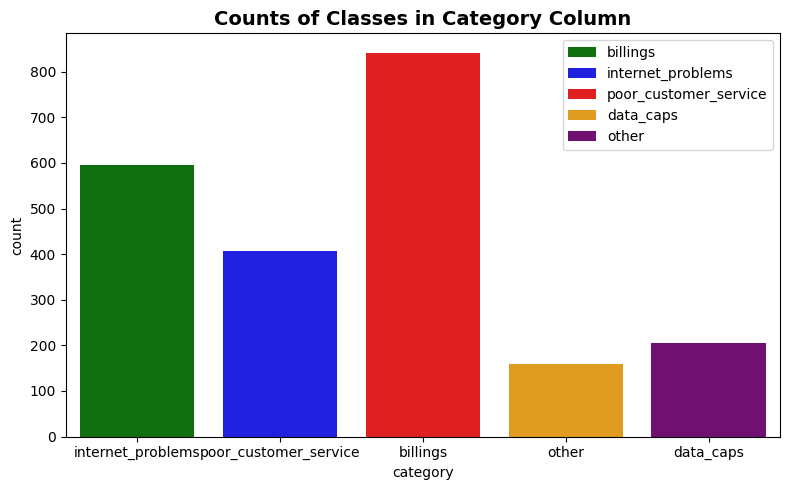

In [ ]:
plt.figure(figsize=(8,5), dpi=100)
# use seaborn countplot to plant the number of occurrences of each class in the dataset
sns.countplot(
        x = 'category',
        data=primary_data,
        dodge=False,
        hue = 'category',
        palette=config.CLASS_PALETTE
        )
plt.title('Counts of Classes in Category Column', fontsize = 14, fontweight='bold')
plt.legend(labels=config.CLASSES,
            loc='upper right',
            bbox_to_anchor=(1,1))
plt.tight_layout()
plt.savefig('image_files/Count of Classes in Category Column.png')
plt.show()

From the plot above, there is no class with over 50% instances in the dataset. The 'other' and the 'data_caps' classes are the most under-represented in the dataset with a combined size of about 16%. The billings class is the most dominant in the dataset, accounting for almost 40% of its size. 

Next, we investigate the 'state' column of the dataset. The aim here is to identify the states with the most instances in the dataset. We look at the top ten states with respect to the number of instances in the dataset.

In [ ]:
primary_data['state'].value_counts()

Georgia                 288
Florida                 234
California              220
Illinois                164
Tennessee               140
Pennsylvania            129
Michigan                114
Washington               98
Colorado                 80
Maryland                 78
New Jersey               75
Texas                    71
Massachusetts            61
Virginia                 60
Indiana                  57
Oregon                   48
Mississippi              39
Minnesota                33
Alabama                  26
Utah                     22
Arizona                  20
South Carolina           18
District Of Columbia     17
New Mexico               15
Louisiana                13
Connecticut              12
Delaware                 12
West Virginia            11
New Hampshire            11
Kentucky                  7
Arkansas                  6
Maine                     5
New York                  5
Missouri                  4
Ohio                      3
North Carolina      

It is important to note here that not all the staes in the US are in the dataset. How many states are in the dataset?

In [ ]:
number_of_states = len(primary_data['state'].value_counts())
print(f'There are {number_of_states} states in the dataset')

There are 42 states in the dataset


From the counts of categories by states, it appears few states account for most of the categories in the dataset. Let's see if this is correct by visualising the composition of the categories column by states. To do this, we group the category column by the state column and arrange the resulting dataframe in ascending order.

In [ ]:
#group the dataset by state and category
grouped_by = eda_utils.EdaDf(primary_data).group_by('category', 'state')
#get the grouped dataset ready to be plotted. 
#creata a top_n states table with the percentage count of categories for each top_n  top_n state
top_states = eda_utils.EdaDfPlotReady(grouped_by).top_states_count_df()
print(top_states)

  state_group  count_of_category  percent_count
0       total               2208            100
1       top_5               1046             47
2      top_10               1545             70
3      top_15               1869             85
4      top_20               2037             92


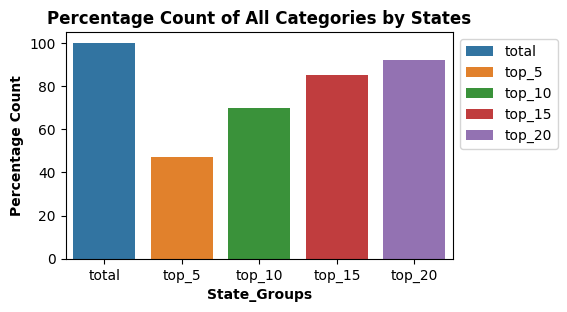

In [ ]:
eda_utils.Plot(top_states).plot_percent_count_top_states('All Categories')

The plot shows that the top_5 states account for almost 50% of the instances we have in the dataset. After the top_20 states, the other 22 states account for less than 10% of the values in the target column. This implies the complaints received from the customers are mostly coming from less than half the number of states.

There may be few states where most of the complaints come from, can the same be said if we look at the different classes of complaints? Is the 'internet problem' also coming from only a few states? What is the distribution of the states with respect to the individual categories?

Let's create a dataframe grouped by the classes in the target column and the states. This dataframe is sliced using the classes to produce one dataframe grouped by states for every class. These dataframes are then used to generate the top states plot for each class like we did for the 5 classes in the dataset.

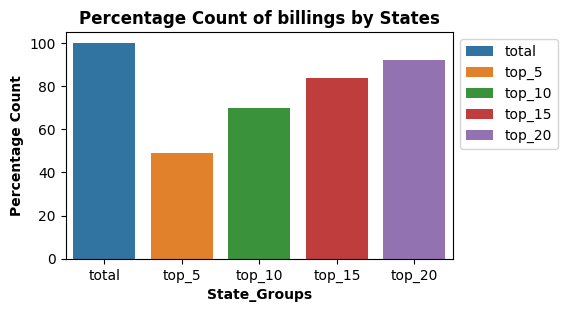

In [ ]:
#group the dataset by category and then by state
grouped_by_category = eda_utils.EdaDf(primary_data).group_by('state', 'category', 'state')
#use the grouped dataset to generate a top_n states table for billing category
top_states_billings = eda_utils.EdaDfPlotReady(grouped_by_category).top_states_count_df('billings')
#plot a barplot for the top_n state table
eda_utils.Plot(top_states_billings).plot_percent_count_top_states('billings')

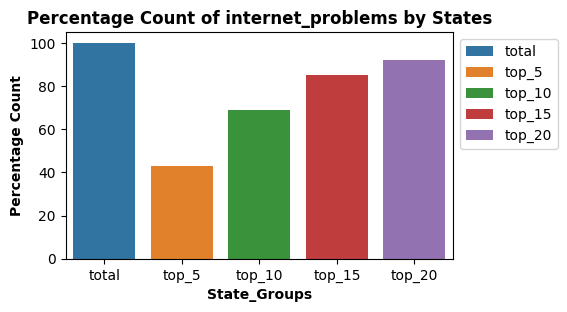

In [ ]:
#group the dataset by category and then by state
grouped_by_category = eda_utils.EdaDf(primary_data).group_by('state', 'category', 'state')
#use the grouped dataset to generate a top_n states table for internet_problems category
top_states_internet = eda_utils.EdaDfPlotReady(grouped_by_category).top_states_count_df('internet_problems')
#plot a barplot for the top_n state table
eda_utils.Plot(top_states_internet).plot_percent_count_top_states('internet_problems')

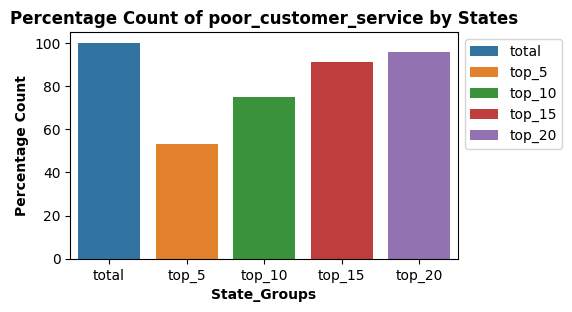

In [ ]:
#group the dataset by category and then by state
grouped_by_category = eda_utils.EdaDf(primary_data).group_by('state', 'category', 'state')
#use the grouped dataset to generate a top_n states table for poor_customer_service category
top_states_customer = eda_utils.EdaDfPlotReady(grouped_by_category).top_states_count_df('poor_customer_service')
#plot a barplot for the top_n state table
eda_utils.Plot(top_states_customer).plot_percent_count_top_states('poor_customer_service')

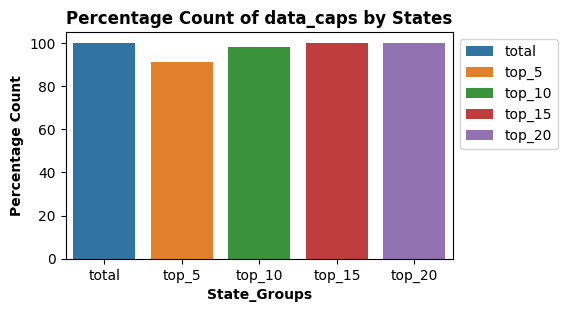

In [ ]:
#group the dataset by category and then by state
grouped_by_category = eda_utils.EdaDf(primary_data).group_by('state', 'category', 'state')
#use the grouped dataset to generate a top_n states table for data-caps category
top_states_data = eda_utils.EdaDfPlotReady(grouped_by_category).top_states_count_df('data_caps')
#plot a barplot for the top_n state table
eda_utils.Plot(top_states_data).plot_percent_count_top_states('data_caps')

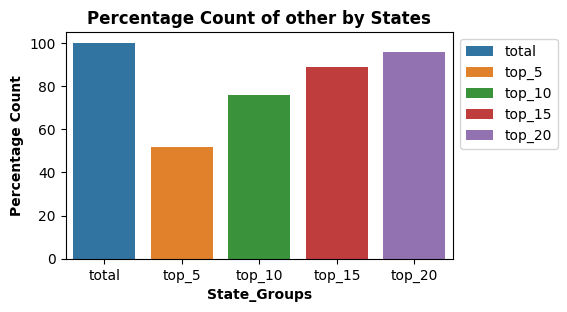

In [ ]:
#group the dataset by category and then by state
grouped_by_category = eda_utils.EdaDf(primary_data).group_by('state', 'category', 'state')
#use the grouped dataset to generate a top_n states table for other category
top_states_other = eda_utils.EdaDfPlotReady(grouped_by_category).top_states_count_df('other')
#plot a barplot for the top_n state table
eda_utils.Plot(top_states_other).plot_percent_count_top_states('other')

It can be observed that for the individual classes, there are also few states that account for most of the complaints in the dataset.

We can also identify the states that featured in the top 10 states for the different classes.

In [ ]:
#group the dataset by category and then by state
grouped_by_category = eda_utils.EdaDf(primary_data).group_by('state', 'category', 'state')
#prepare the dataframe for slicing based on category
category_by_state_df = eda_utils.EdaDfPlotReady(grouped_by_category).state_category_plot()
top_ten_list = []
for category in category_by_state_df['category'].unique():
    value = category_by_state_df[category_by_state_df['category'] == category]
    value.sort_values(by='count_by_state', ascending=False, inplace = True)
    top_ten_list.append(value)
#convert the elemnet in the top_ten_list to sets
#compute the intersection of the sets
common_states = set(top_ten_list[0]['state'][:10]).intersection(
    set(top_ten_list[1]['state'][:10]),
    set(top_ten_list[2]['state'][:10]),
    set(top_ten_list[3]['state'][:10]),
    set(top_ten_list[4]['state'][:10])
)
    
print(f'The common states in the top ten states for every category are {common_states}')


The common states in the top ten states for every category are {'Illinois', 'Georgia'}


## 4.0 Common Words
Let's go through the descriptions columns in the dataset and see if there are frequently used words that can give us any indication of the most common complaints from comcast customers. The classes in the target column of the dataset is essentially the main points in the descriptions column of the dataset. If there are high frequent words from the description column that cannot be linked to any of the classes in the dataset, then there may be need to introduce new classes or reclassify the dataset.

To accomplish this, punctuations and common words from everyday english need to be removed from the text. Then we proceed to generate the first 20 most common words.

In [ ]:
top_N = 20
#extract the text from the description column of the dataset
txt_extract = primary_data.description
txt_extract = txt_extract.apply(lambda x: re.sub(r'[^\w\s|\$]', '', x))
txt = txt_extract.str.lower().str.replace(r'\|', ' ').str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(txt)
word_dist = nltk.FreqDist(words)
#remove stopwords
stopwords = nltk.corpus.stopwords.words('english')
words_except_stop_dist = nltk.FreqDist(w for w in words if w not in stopwords) 

result = pd.DataFrame(words_except_stop_dist.most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')

In [ ]:
print('All frequencies, excluding STOPWORDS:')
print(result)

All frequencies, excluding STOPWORDS:
             Frequency
Word                  
fcc               9164
comcast           6286
notice            5256
service           5055
complaint         4655
response          4184
internet          3714
message           3240
followup          3119
days              2977
$                 2868
copy              2548
would             2512
consumer          2314
carrier           2309
company           2181
due               2162
please            2156
see               2115
information       2088


We can find that some of the most common words can be linked to the classes in the dataset. Words like internet, service, $, and followup can be associated with the internet_problem, poor_customer_service and billings classes in the dataset. We can say with some air of certainty that the descriptions column has been correctly classified.

## 5.0 Trend of Complaints
The complaints from the customers are in the descriptions column of the dataset. We can check if there is a pattern to these complaints over the period of time they were documented. The check can also be extended to the individual classes of the dataset to see if their patterns follow the trend in the combined classes.

First, let us find out the data type of the data column

In [ ]:
primary_data.date.dtypes

dtype('O')

The data is an object data type. We need it to be a datetime data type.

In [ ]:
#convert to datatime datatype
primary_data['date'] = pd.to_datetime(primary_data['date'])

Let's check the datatype of the date column again

In [ ]:
primary_data.date.dtypes

dtype('<M8[ns]')

These complaints were gathered over a period of time. For how long?

In [ ]:
max_date = primary_data['date'].max()
min_date = primary_data['date'].min()
duration = max_date - min_date
print(f'The length of time the complaints were received is {duration} days')

The length of time the complaints were received is 90 days 00:00:00 days


We can explore if there is any trend over this period of time. Essentially we want to establish if the complaints are a one-time disruption in services or they happened over a period of time.

In [ ]:
#group the dataset by category and then by date
grouped_by_date = eda_utils.EdaDf(primary_data).group_by('category', 'category', 'date')
#prepare the dataset for plotting
grouped_by_date = eda_utils.EdaDfPlotReady(grouped_by_date).date_plot()
grouped_by_date.head()

,category,date,count_by_date
0,billings,2015-04-01,6
1,billings,2015-04-02,10
2,billings,2015-04-03,4
3,billings,2015-04-04,5
4,billings,2015-04-05,1


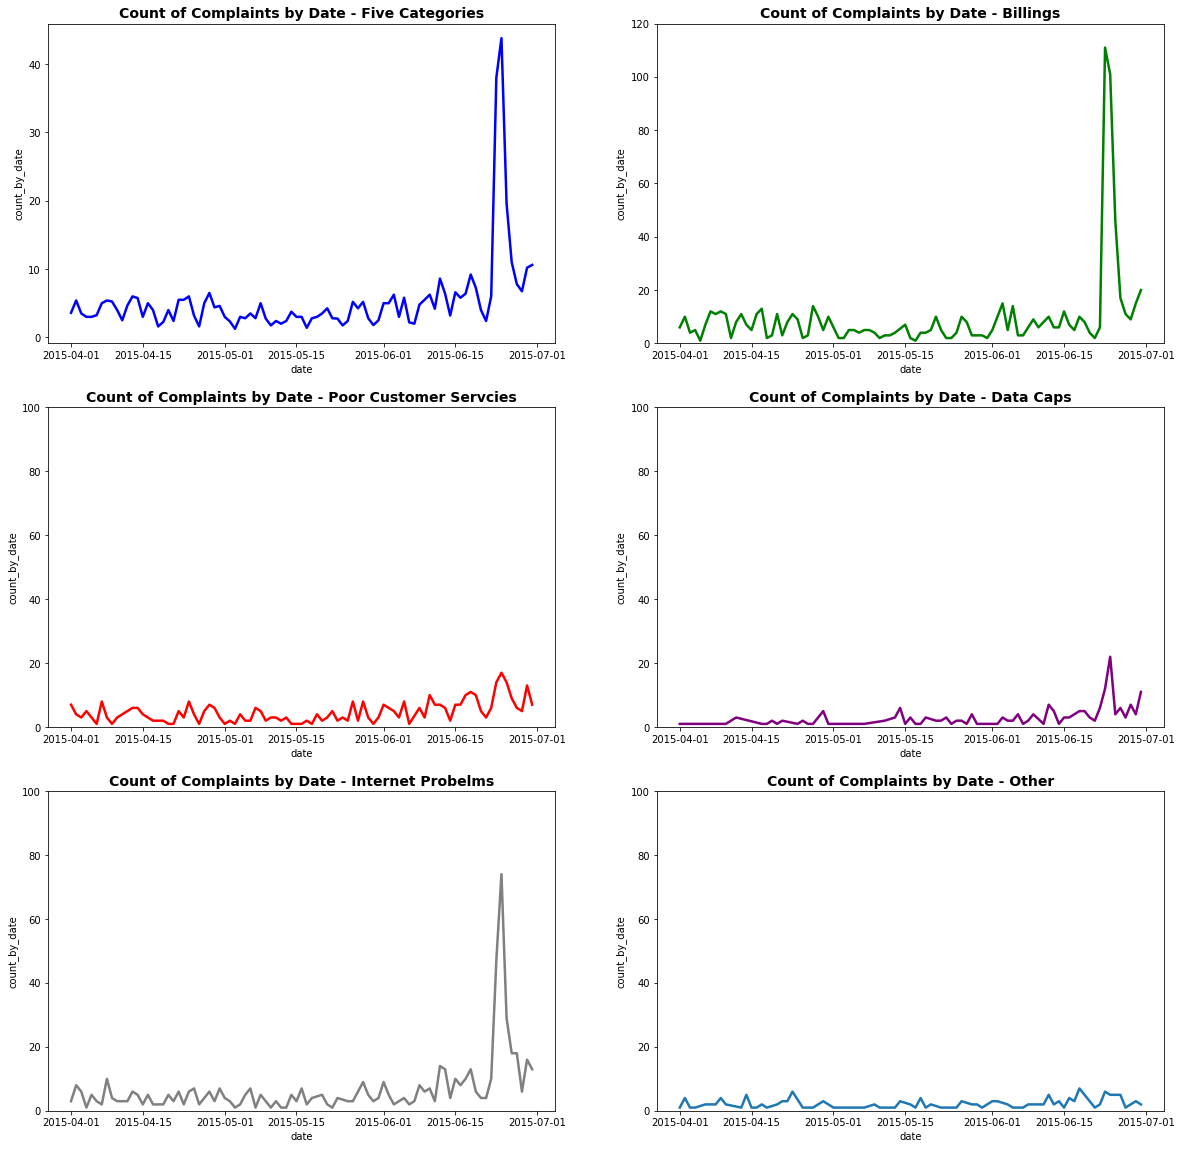

In [ ]:
eda_utils.Plot(grouped_by_date).plot_category_trend()

The trends of the individual classes are quite similar to the trend of the combined classes. There is no cyclical patterns to these trends. This indicates that the problems are actually persistent over the period. The persistency of these complaints could actually explain why the FCC fined comcast such huge sum of money.

## 6.0 Conclusion
The dataset has 2208 rows and 7 columns. The columns of interest are the category and descriptions columns. The dataset is a multi-class dataset with 5 classes. The billing class is the dominant class, nevertheless the dataset cannot be described as highly imbalanced. Of the 43 states included in the dataset, few make about are responsible for over 50% of the compalints recorded in the dataset. The most common words we find in the description column corresponds to the classes in the dataset. Finally, the complaints did not show any cyclical patterns and seemed to be persistent over the period of recording the complaints.

The next step is modelling.
